# Identifying Consumer Demographic Groups Using Convolutional Neural Networks
by Kevin Atkinson

## Business Understanding
Two of the major factors in advertising products to consumers are age and gender. While there are many factors in ascertaining the most optimal product advertisements to serve to an individual, these two to encompass a large portion of the equation. In this project we will attempt to use images of individuals to classify their age and gender to better target ads to individuals. 

One such application for this technology would be a cosmetics retail store such as an Ulta or Sephora. Using in-store cameras to identify the demographics of individual customers and display targeted advertisements locally.


## Data Understanding

Our data is being sourced from the [B3FD](https://github.com/kbesenic/B3FD) dataset. We will be using subsets that have the classification targets of Age and Gender

In [426]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import keras
import tensorflow as tf
import visualkeras
from keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from keras.layers import Activation, Add, AveragePooling2D, BatchNormalization, Conv2D, Dense, Flatten, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [365]:
imdb = pd.read_csv('B3FD_metadata/B3FD-IMDB_age_gender.csv', delimiter=' ')
wiki = pd.read_csv('B3FD_metadata/B3FD-WIKI_age_gender.csv', delimiter=' ')

In [366]:
len(imdb), len(wiki)

(204514, 40690)

In [367]:
df = pd.concat([imdb, wiki])
df = df.reset_index(drop=True)
df.tail()

,path,age,gender
245199,mariajookoehler/22656187_1992-10-08_2015.jpg,23,F
245200,willdemps/1805168_1979-11-07_2007.jpg,28,M
245201,pierreallen/32740287_1987-11-18_2012.jpg,25,M
245202,patdecola/30326918_1987-06-30_2011.jpg,24,M
245203,ullazirne/42028665_1995-08-06_2012.jpg,17,F


In [368]:
len(df)

245204

In [369]:
# Checking to see if we have any null values
df.isna().sum()

path      0
age       0
gender    0
dtype: int64

In [370]:
# Determining how many unique ages we have
len(df['age'].value_counts())

102

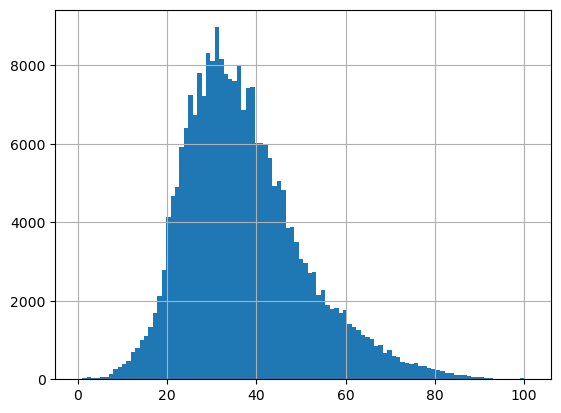

In [371]:
df['age'].hist(bins=102);

In [372]:
df['gender'].value_counts()

M    141038
F    104166
Name: gender, dtype: int64

According to [PickFu.com](https://www.pickfu.com/demographic-segmentation), Marketing demographic age groups are typically: 18-24, 25-34, 35-44, 45-54, 55-64, and 65 and older

We'll split the ages into these groups using .apply and a function.

We're not interested in advertising to individuals under age 18, so we can drop those from our data set.

In [373]:
def age_split(age):
    if age < 18:
        return 'X'
    if age in range(18,25):
        return 'A'
    if age in range(25,35):
        return 'B'
    if age in range(35,45):
        return 'C'
    if age in range(45,55):
        return 'D'
    if age in range(55,65):
        return 'E'
    else:
        return 'F'

In [374]:
df['age'] = df['age'].apply(age_split)

In [375]:
df.head()

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,C,F
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,E,M
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,E,M
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,E,M
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,E,M


In [376]:
df['age'].value_counts()

B    78027
C    65902
D    34742
A    30926
E    16371
F    10792
X     8444
Name: age, dtype: int64

In [377]:
# Dropping indiviudals under 18
df = df.drop(df.loc[df['age'] == 'X'].index)
df = df.reset_index(drop=True)

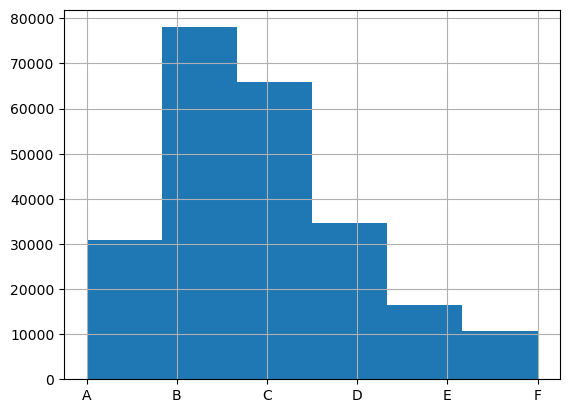

In [378]:
df['age'].sort_values().hist(bins=6);

We have a large class imbalance between our age groups, with group F (65+) having ~11k examples, whereas group B (25-34) has ~80k examples. This could cause problems later on during modeling, where our model could overfit to the Group B and underfit to Group F. Let's proceed as is and determine later on if we must address this, and if so how.

Now that we have our data cleaned and classified, let's split it into file paths and targets.

In [379]:
ohe = OneHotEncoder(sparse=False)
age = ohe.fit_transform(df[['age']]).tolist()
df['age'] = age
df['gender'] = df['gender'].str.get_dummies()['M']
df.head(10)

,path,age,gender
0,sarasugarman/nm0837406_rm2246023424_1965-10-13...,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0
1,fredwillard/nm0929609_rm3469383936_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
2,fredwillard/nm0929609_rm526752256_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
3,fredwillard/nm0929609_rm4210202880_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
4,fredwillard/nm0929609_rm275094016_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
5,fredwillard/nm0929609_rm509975040_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",1
6,fredwillard/nm0929609_rm924956672_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
7,fredwillard/nm0929609_rm102873088_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
8,fredwillard/nm0929609_rm119650304_1939-9-18_20...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
9,fredwillard/nm0929609_rm3704002560_1939-9-18_2...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1


In [380]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [381]:
len(df_train), len(df_test)

(189408, 47352)

Because we will need to use multiple Image Data Generators, we can create a function that will enable these to be created more easily.

In [382]:
def ImgGen(dataframe, img_size=(128,128), batch_size=32, brightness=[0.7, 1.3], vsplit=0.2, rrange=15, seed=2023, shuffle=True):

    dir = os.getcwd() + '\\B3FD\\'

    train_datagen = ImageDataGenerator(validation_split=vsplit, rotation_range=rrange, fill_mode='nearest',
                                       brightness_range=brightness, rescale=1./255)
    
    val_datagen = ImageDataGenerator(validation_split=vsplit, rescale=1./255)
    
    train_gen = train_datagen.flow_from_dataframe(dataframe, dir, x_col='path', y_col=['age', 'gender'], class_mode='multi_output', batch_size=batch_size,
                                                  target_size=img_size, subset='training', shuffle=shuffle, seed=seed)
    
    val_gen = val_datagen.flow_from_dataframe(dataframe, dir, x_col='path', y_col=['age', 'gender'], class_mode='multi_output', batch_size=batch_size,
                                                  target_size=img_size, subset='validation', shuffle=shuffle, seed=seed)
    

    return train_gen, val_gen

We'll also create a function to plot the results of our model training

In [418]:
def plot_history(history):
    train_loss = history.history['loss']
    train_age_loss = history.history['age_loss']
    train_gender_loss = history.history['gender_loss']
    train_age_acc = history.history['age_accuracy']
    train_gender_acc = history.history['gender_accuracy']

    val_loss = history.history['val_loss']
    val_age_loss = history.history['val_age_loss']
    val_gender_loss = history.history['val_gender_loss']
    val_age_acc = history.history['val_age_accuracy']
    val_gender_acc = history.history['val_gender_accuracy']

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 7.5))

    ax1.set_title('Loss')
    # ax1.set_ylim([0, None])
    sns.lineplot(x=history.epoch, y=train_loss, ax=ax1, label='Training Loss')
    sns.lineplot(x=history.epoch, y=val_loss, ax=ax1, label='Validation Loss')

    ax2.set_title('Loss by Target')
    sns.lineplot(x=history.epoch, y=train_age_loss, ax=ax2, label='Training Loss: Age')
    sns.lineplot(x=history.epoch, y=train_gender_loss, ax=ax2, label='Training Loss: Gender')
    sns.lineplot(x=history.epoch, y=val_age_loss, ax=ax2, label='Validation Loss: Age')
    sns.lineplot(x=history.epoch, y=val_gender_loss, ax=ax2, label='Validation Loss: Gender')

    ax3.set_title('Accuracy')
    ax3.set_ylim([0, None])
    sns.lineplot(x=history.epoch, y=train_age_acc, ax=ax3, label='Training Accuracy: Age')
    sns.lineplot(x=history.epoch, y=train_gender_acc, ax=ax3, label='Training Accuracy: Gender')
    sns.lineplot(x=history.epoch, y=val_age_acc, ax=ax3, label='Validation Accuracy: Age')
    sns.lineplot(x=history.epoch, y=val_gender_acc, ax=ax3, label='Validation Accuracy: Gender')

In [383]:
train_gen, val_gen = ImgGen(df_train, img_size=(64,64))

Found 151527 validated image filenames.
Found 37881 validated image filenames.


In [384]:
# Checking that our train and val generators are working as expected
gen_check = train_gen.filenames + val_gen.filenames
len(gen_check) == len(set(gen_check))

True

Let's also create a test generator to be used later to evaluate our model(s).

In [423]:
test_gen, null_gen = ImgGen(df_test, img_size=(64,64), vsplit=0, brightness=None, rrange=0, shuffle=False)

Found 47352 validated image filenames.
Found 0 validated image filenames.


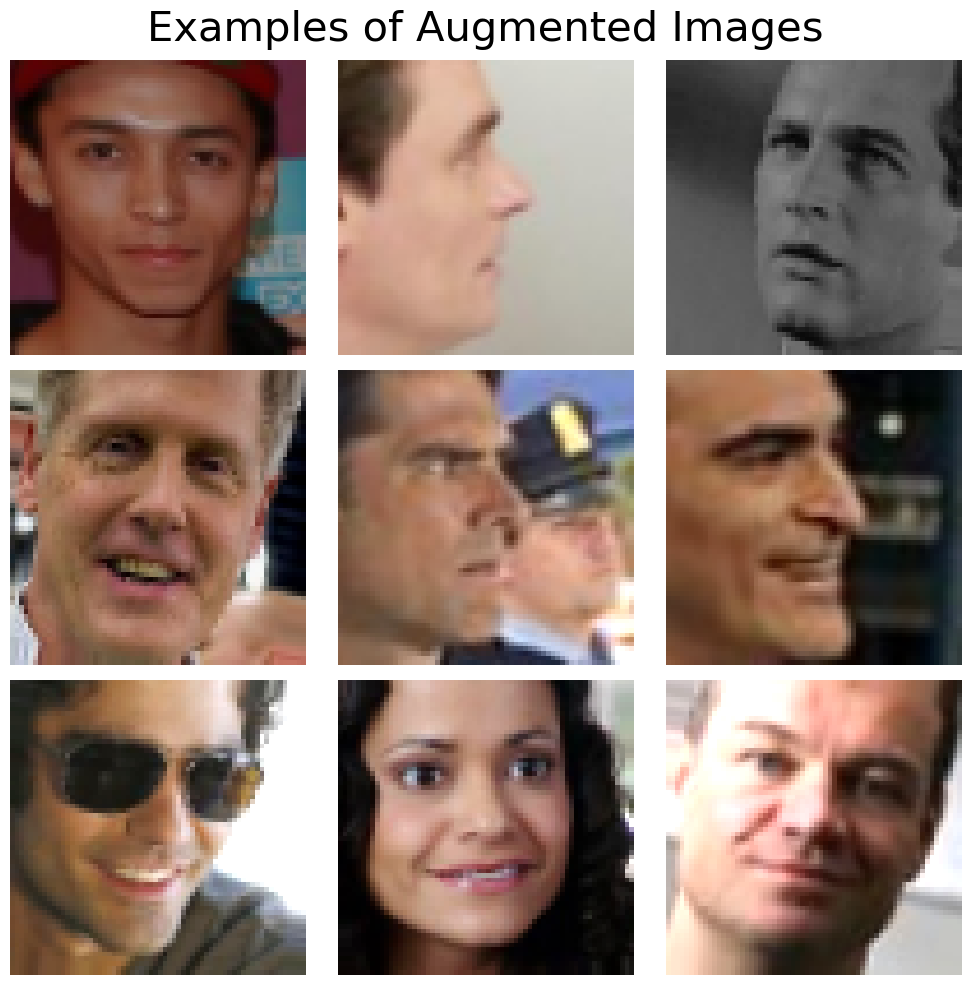

In [385]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
# Create list for labeling images
groups = {'A': '18-24', 'B': '25-34', 'C': '35-44', 'D': '45-54', 'E': '55-64', 'F': '65+'}
img, label = train_gen.next()
for i, ax in enumerate(axes.flat):
    # title = f'Age: {groups[label[0][i]]}, Gender: {label[1][i]}'
    ax.imshow(img[i])
    # ax.set(title=f"{title}")
    ax.axis('off')
fig.suptitle('Examples of Augmented Images', fontsize=30)
plt.tight_layout()
plt.show()
one_image = img[0]

### Model 1

In [386]:
def layer_block(x, filter):
    # copying input x
    x_resid = x

    # conv layer 1
    x = Conv2D(filter, kernel_size=(3,3), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # conv layer 2
    x = Conv2D(filter, kernel_size=(3,3), padding='same')(x)
    x = BatchNormalization()(x)
    
    # creating residual connection
    x_resid = Conv2D(filter, kernel_size=3, strides=(2,2), padding='same')(x_resid)
    x = Add()([x, x_resid])
    x = Activation('relu')(x)

    return x 


In [396]:
def make_model(shape=(64,64,3)):
    filter_size = 128
    
    # first layer and pooling
    input_layer = keras.Input(shape=shape, name='input_layer')
    x = Conv2D(128, kernel_size=(3,3), padding='same')(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides=(2,2), padding='same')(x)

    # cycle through layer blocks
    for i in range(4):
        if i > 0:
            filter_size *= 2
        x = layer_block(x, filter_size)
    
    # penultimate layer
    x = AveragePooling2D((2,2), padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    
    # output layers
    age_output = Dense(6, activation='softmax', name='age')(x)
    gender_output = Dense(1, activation='sigmoid', name='gender')(x)

    model = keras.Model(inputs=input_layer, outputs=[age_output, gender_output])
    return model


In [397]:
model = make_model()

In [398]:
model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input Layer (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d_409 (Conv2D)            (None, 64, 64, 128)  3584        ['Input Layer[0][0]']            
                                                                                                  
 batch_normalization_281 (Batch  (None, 64, 64, 128)  512        ['conv2d_409[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_279 (Activation)    (None, 64, 64, 128)  0           ['batch_normalization_281[

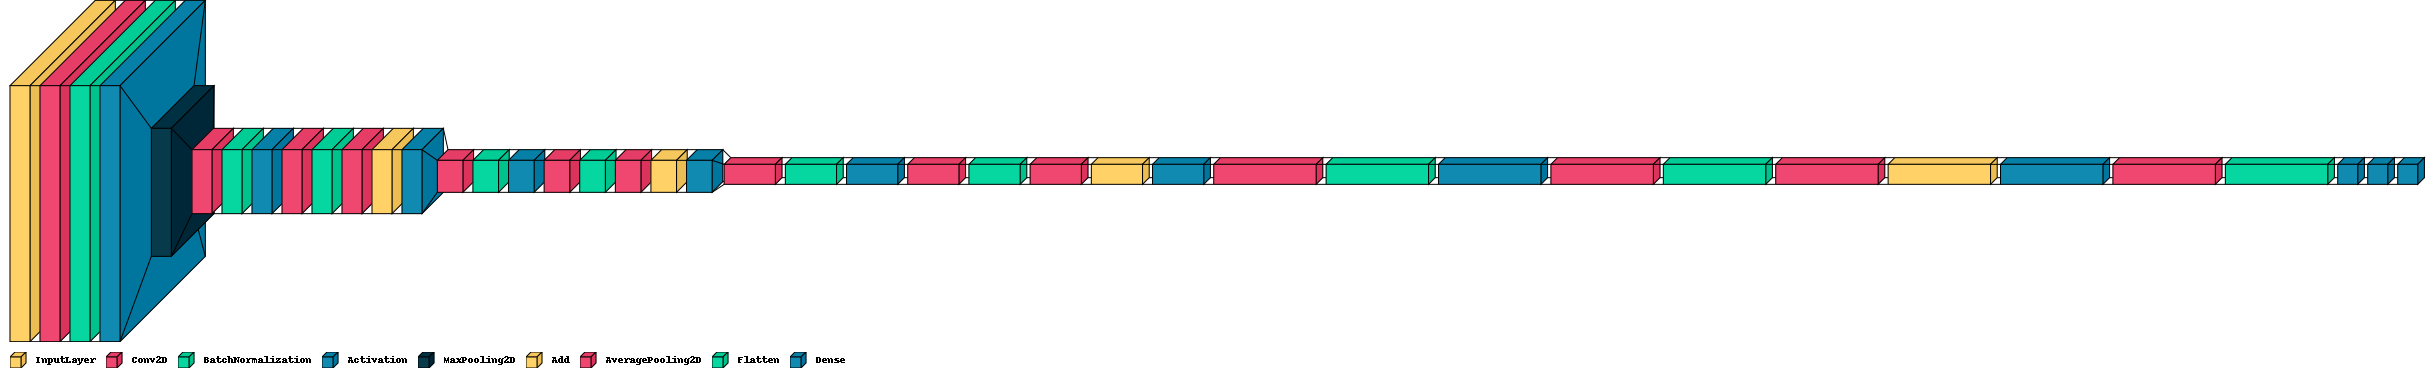

In [430]:
visualkeras.layered_view(model, legend=True)

In [399]:
model.compile(optimizer='adam', loss=[CategoricalCrossentropy(), BinaryCrossentropy()], loss_weights=[50,1], metrics=['accuracy'])

In [400]:
results = model.fit(train_gen, epochs=50, validation_data=val_gen, validation_steps=100//train_gen.batch_size)

Epoch 1/50
4736/4736 [==============================] - 4503s 950ms/step - loss: 72.9302 - age_loss: 1.4472 - gender_loss: 0.5728 - age_accuracy: 0.3776 - gender_accuracy: 0.6971 - val_loss: 70.8872 - val_age_loss: 1.4054 - val_gender_loss: 0.6172 - val_age_accuracy: 0.4062 - val_gender_accuracy: 0.6771
Epoch 2/50
4736/4736 [==============================] - 4497s 950ms/step - loss: 66.1480 - age_loss: 1.3120 - gender_loss: 0.5498 - age_accuracy: 0.4261 - gender_accuracy: 0.7078 - val_loss: 68.9408 - val_age_loss: 1.3682 - val_gender_loss: 0.5286 - val_age_accuracy: 0.4896 - val_gender_accuracy: 0.7292
Epoch 3/50
4736/4736 [==============================] - 4444s 938ms/step - loss: 63.5924 - age_loss: 1.2609 - gender_loss: 0.5460 - age_accuracy: 0.4457 - gender_accuracy: 0.7090 - val_loss: 63.3470 - val_age_loss: 1.2548 - val_gender_loss: 0.6079 - val_age_accuracy: 0.4271 - val_gender_accuracy: 0.6667
Epoch 4/50
4736/4736 [==============================] - 4584s 968ms/step - loss: 61.3

In [407]:
results.history.keys()

dict_keys(['loss', 'age_loss', 'gender_loss', 'age_accuracy', 'gender_accuracy', 'val_loss', 'val_age_loss', 'val_gender_loss', 'val_age_accuracy', 'val_gender_accuracy'])

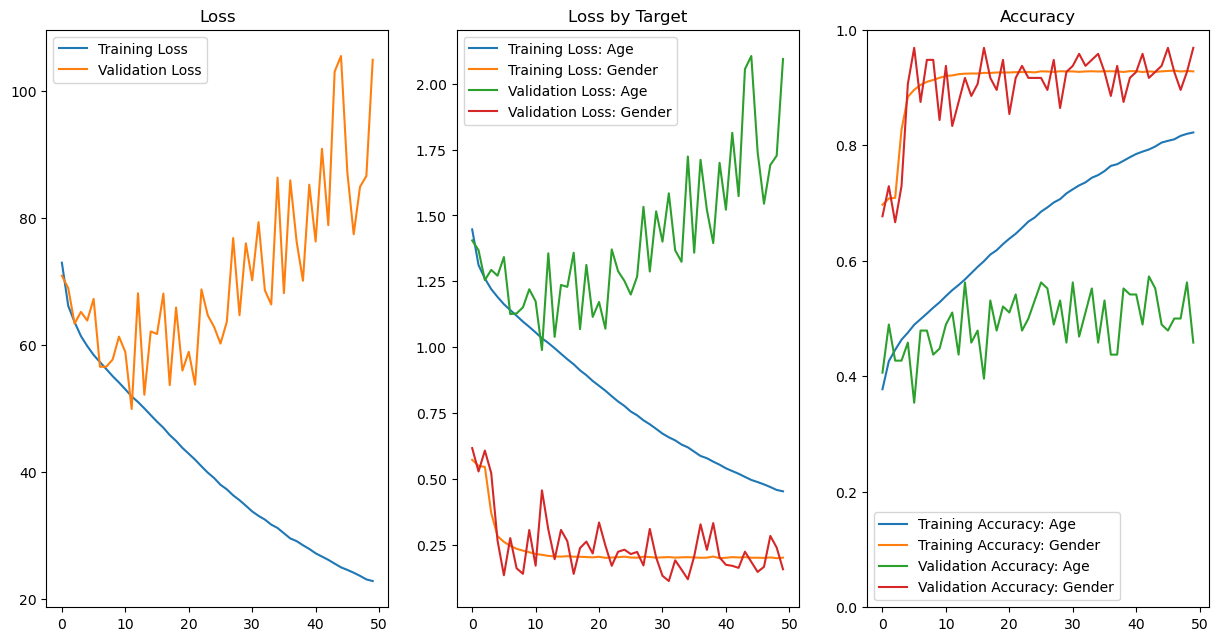

In [419]:
plot_history(results)

In [446]:
model.save_weights('models/model1_weights')


It seems our model is majorly overfitting to training data. To remedy this, we can add dropout. We can also increase the pixel counts from (64,64) to (128,128).